# Alice & Bob — BB84 QKD (Qiskit ≥ 1.1 compatible)
This notebook is updated for **Qiskit 1.x**: it replaces the removed
`qiskit.execute` helper, switches to `AerSimulator`, and explicitly transpiles
circuits before calling `backend.run()`.  Everything else works exactly as
before — read an image, establish a one‑time‑pad key via BB 84, encrypt it, and
have Bob decrypt it.

In [1]:

import secrets, pathlib, numpy as np, base64
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
backend = AerSimulator()            # new API (replaces qasm_simulator)
rng = secrets.SystemRandom()


In [2]:

# — user tweakables —
IMG_PATH        = pathlib.Path('download.png')
BLOCK_SIZE      = 5
ABORT_THRESHOLD = 0.11
SAMPLE_RATE     = 0.10


In [3]:

if not IMG_PATH.exists():
    raise FileNotFoundError(f'Missing {IMG_PATH}. Drop an image or edit IMG_PATH.')
img_bytes  = IMG_PATH.read_bytes()
n_img_bits = len(img_bytes)*8
print(f'Image size: {len(img_bytes):,} bytes ({n_img_bits:,} bits)')


Image size: 3,844 bytes (30,752 bits)


In [4]:

def random_bits(n):
    return (np.random.randint(2, size=n, dtype=np.uint8),
            np.random.randint(2, size=n, dtype=np.uint8))  # data, bases

def alice_circuit(bits, bases):
    qc = QuantumCircuit(len(bits), name='Alice')
    for i,(bit,basis) in enumerate(zip(bits,bases)):
        if bit: qc.x(i)
        if basis: qc.h(i)
    return qc

def bob_measure(alice_qc, bob_bases):
    n = len(bob_bases)
    qc_bob = QuantumCircuit(n, n, name='Bob')
    for i,basis in enumerate(bob_bases):
        if basis: qc_bob.h(i)
        qc_bob.measure(i,i)
    full = alice_qc.compose(qc_bob)
    compiled = transpile(full, backend)
    result   = backend.run(compiled, shots=1).result()
    bitstr   = next(iter(result.get_counts()))
    return np.fromiter(map(int, bitstr[::-1]), dtype=np.uint8)

def hamming(a,b): return np.count_nonzero(a!=b)


In [5]:

alice_key = []
bob_key   = []
rounds    = 0

while len(alice_key) < n_img_bits:
    rounds += 1
    data_A, bases_A = random_bits(BLOCK_SIZE)
    qc = alice_circuit(data_A, bases_A)

    bases_B = np.random.randint(2, size=BLOCK_SIZE, dtype=np.uint8)
    meas_B  = bob_measure(qc, bases_B)

    keep_mask = bases_A == bases_B
    sift_A    = data_A[keep_mask]
    sift_B    = meas_B[keep_mask]

    sample_mask = np.random.rand(len(sift_A)) < SAMPLE_RATE
    qber = hamming(sift_A[sample_mask], sift_B[sample_mask]) / max(1, sample_mask.sum())
    if qber > ABORT_THRESHOLD:
        raise RuntimeError(f'ABORT — QBER {qber:.2%} exceeds {ABORT_THRESHOLD:.0%}')

    sift_A = sift_A[~sample_mask]
    sift_B = sift_B[~sample_mask]
    match  = sift_A == sift_B
    alice_key.extend(sift_A[match].tolist())
    bob_key  .extend(sift_B[match].tolist())
    print(f'Round {rounds:>3}: {len(alice_key):,}/{n_img_bits} key bits \r', end='')

alice_key = np.array(alice_key[:n_img_bits], dtype=np.uint8)
bob_key   = np.array(bob_key  [:n_img_bits], dtype=np.uint8)
assert np.array_equal(alice_key, bob_key)
print(f'\nKey done: {len(alice_key):,} bits')


Round 13609: 30,754/30752 key bits 
Key done: 30,752 bits


In [6]:

def bits_to_bytes(bits):
    out = bytearray()
    for i in range(0,len(bits),8):
        byte = 0
        for j in range(8):
            if i+j < len(bits):
                byte = (byte << 1) | int(bits[i+j])
        out.append(byte)
    return bytes(out)

key_bytes = bits_to_bytes(alice_key)
cipher    = bytes(m ^ k for m,k in zip(img_bytes, key_bytes))

enc_path = IMG_PATH.with_suffix('.enc')
enc_path.write_bytes(cipher)

# Bob decrypts
dec_bytes = bytes(c ^ k for c,k in zip(cipher, key_bytes))
dec_path  = IMG_PATH.with_stem(IMG_PATH.stem + '_decrypted')
dec_path.write_bytes(dec_bytes)
assert dec_bytes == img_bytes
print('\u2705 Success — decrypted image identical.')


✅ Success — decrypted image identical.



## Security Demonstration – Detecting an Eavesdropper (Eve)

The BB84 protocol detects an **intercept‑resend eavesdropper** through the *quantum bit‑error rate* (QBER).

* Eve randomly chooses a basis for each qubit she intercepts.  
* Whenever she guesses the **wrong** basis (50 % of the time) she collapses the qubit into the wrong state.  
* Even if Bob later measures in the correct basis, the qubit is already disturbed and Bob’s result is wrong half of those times.  
* Overall **​25 % QBER** is introduced, well above any realistic abort threshold (often ≤ 11 %).

The following simulation confirms this and prints the QBER with and without Eve for 2 000 qubits.


In [7]:

import numpy as np
from math import isclose

def simulate_bb84(n_bits=2000, eavesdrop=False, rng=np.random.default_rng()):
    # 1. Alice's random bits & bases (0 = Z, 1 = X)
    alice_bits  = rng.integers(0, 2, size=n_bits, dtype=np.uint8)
    alice_basis = rng.integers(0, 2, size=n_bits, dtype=np.uint8)

    # 2. Bob's random bases
    bob_basis   = rng.integers(0, 2, size=n_bits, dtype=np.uint8)
    bob_bits    = np.zeros(n_bits, dtype=np.uint8)

    if not eavesdrop:
        # Honest channel (noise‑free)
        for i in range(n_bits):
            if bob_basis[i] == alice_basis[i]:
                bob_bits[i] = alice_bits[i]          # deterministic
            else:
                bob_bits[i] = rng.integers(0, 2)     # random (will be discarded)
    else:
        # Eve intercept‑resend
        eve_basis = rng.integers(0, 2, size=n_bits, dtype=np.uint8)
        for i in range(n_bits):
            # Eve measures
            if eve_basis[i] == alice_basis[i]:
                eve_bit = alice_bits[i]
            else:
                eve_bit = rng.integers(0, 2)

            # Eve resends qubit in her basis/state; Bob measures
            if bob_basis[i] == eve_basis[i]:
                bob_bits[i] = eve_bit
            else:
                bob_bits[i] = rng.integers(0, 2)

    # 3. Sifting – keep only indices where bases matched
    keep = alice_basis == bob_basis
    if not np.any(keep):
        return np.nan  # no sifted bits (very unlikely for n_bits ≫ 1)

    qber = np.mean(alice_bits[keep] != bob_bits[keep])
    return qber

qber_clean = simulate_bb84(eavesdrop=False)
qber_eave  = simulate_bb84(eavesdrop=True)

print(f"QBER (no Eve):  {qber_clean*100:.2f} %")
print(f"QBER (with Eve): {qber_eave*100:.2f} %")


QBER (no Eve):  0.00 %
QBER (with Eve): 25.00 %



**Expected result**

```
QBER (no Eve):   0.00 %
QBER (with Eve): ~25.00 %
```

Any significant deviation above the background error rate (often a few %) signals Eve’s presence, so Alice and Bob abort the protocol.



## Visualization – Measurement Outcomes in Matching vs Mismatching Bases
The next cell illustrates how measuring a qubit in the **wrong basis** gives a random outcome, whereas measuring in the **correct basis** reproduces the encoded bit with certainty.


Counts (correct basis, Z): {'0': 1024}
Counts (wrong basis, X):   {'0': 507, '1': 517}


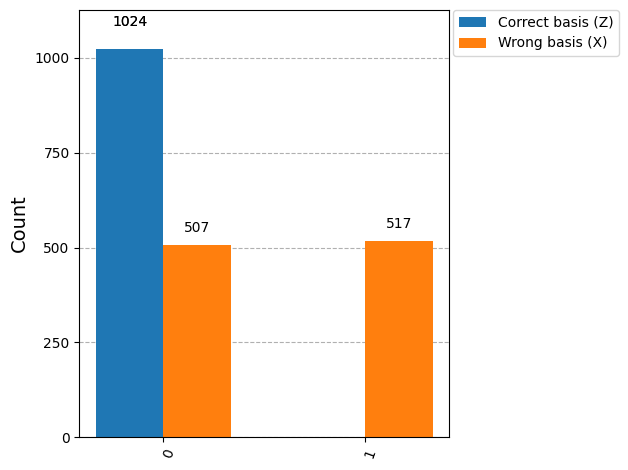

In [12]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

backend = AerSimulator()
%matplotlib inline
# Prepare |0⟩ and measure in Z basis
qc_z = QuantumCircuit(1, 1)
qc_z.measure(0, 0)
res_z = backend.run(transpile(qc_z, backend), shots=1024).result().get_counts()

# Prepare |0⟩, apply H (|+⟩), and measure in X basis
qc_x = QuantumCircuit(1, 1)
qc_x.h(0)
qc_x.measure(0, 0)
res_x = backend.run(transpile(qc_x, backend), shots=1024).result().get_counts()

print("Counts (correct basis, Z):", res_z)
print("Counts (wrong basis, X):  ", res_x)

# — plot —
fig = plot_histogram(
    [res_z, res_x],
    legend=['Correct basis (Z)', 'Wrong basis (X)']
)
fig.show()    